<a href="https://colab.research.google.com/github/ghubnerr/machine-learning/blob/main/autograd/jvps_and_vjps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JVPs and VJPs for Backpropagation in Computation Graphs

`Credits: Gabriel Lucchesi` ([GitHub](https://github.com/ghubnerr))

Article Credits:
```
@article{robeyns2023jvpvjp
    author={Maxime Robeyns},
    title={Of VJPs and JVPs},
    year={2023},
    url={https://maximerobeyns.com/of_vjps_and_jvps},
}
```

In [1]:
import jax
import jax.numpy as jnp
from jax import jit, jacfwd, jacrev
import numpy as np

In [ ]:
def multivariate_computation_graph(inputs):
  x, y, z = inputs
  a = x * y
  b = jnp.sin(z)
  c = a + b
  d = jnp.exp(c)
  return d

def hessian(fun):
  return jit(jacfwd(jacrev(fun)))

f = multivariate_computation_graph
hess_f = hessian(f)

x_val = jnp.array(1.0)
y_val = jnp.array(2.0)
z_val = jnp.array(3.0)

inputs = jnp.array([x_val, y_val, z_val])
hessian_matrix = hess_f(inputs)
print(hess_f, hessian_matrix, sep='\n')


<PjitFunction of <function multivariate_computation_graph at 0x7cc3a8ddcae0>>
[[ 34.035847   25.526886  -16.847616 ]
 [ 25.526886    8.508962   -8.423808 ]
 [-16.847616   -8.423808    7.1387224]]


In [ ]:
variables = ['x', 'y', 'z']
formatted_matrix = []

for i in range(3):
  row = []
  for j in range(3):
    value = round(hessian_matrix[i, j].item(), 2)
    row.append(f"d^2/d{variables[i]}d{variables[j]} = {value}")
  formatted_matrix.append(row)

for row in formatted_matrix:
    print("  ".join(row))


d^2/dxdx = 34.04  d^2/dxdy = 25.53  d^2/dxdz = -16.85
d^2/dydx = 25.53  d^2/dydy = 8.51  d^2/dydz = -8.42
d^2/dzdx = -16.85  d^2/dzdy = -8.42  d^2/dzdz = 7.14


# Backpropagation with `jacrev` and `jacfwd`

$$
\mathbf{J} =
\begin{bmatrix}
\nabla_{\mathbf{x}} f_{1}(\mathbf{x})  \\
\nabla_{\mathbf{x}} f_{2}(\mathbf{x})  \\
\vdots \\
\nabla_{\mathbf{x}} f_{m}(\mathbf{x})  
\end{bmatrix}=
\begin{bmatrix}
\frac{\partial y_{1}}{\partial x_{1}} & \frac{\partial y_{1}}{\partial x_{2}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial y_{m}}{\partial x_{1}} & \frac{\partial y_{m}}{\partial x_{2}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
\end{bmatrix}.
$$


The left-multiplication of the Jacobian by some vector, while the Jacobian-vector product (JVP) is the right-multiplication of the Jacobian by an appropriately shaped vector


## Formulas:
### VJP (a row-vector) $\rightarrow$ Rev AD
$$
\mathbf{u}^{\top}\mathbf J \in \mathbb R^{1 \times n}.
$$
Being $n$-dimensional, we have one VJP element for each of the function inputs,
$\mathbf x$ (it is an ‘input space’ concept).

It tells us “in what direction should each of the inputs change, in order to get (as close as possible to) a change of $\mathbf u$ in the outputs?"

### JVP (a column-vector) $\rightarrow$ Fwd AD
$$\mathbf{J}\mathbf{v} \in \mathbb R ^m$$

Being $m$-dimensional, we have one JVP element for each of the function outputs, $\mathbf y$ (it is an ‘output space’ concept).

It tells us “in what direction do the outputs of $f$ change if I make a perturbation $\mathbf v$ to the inputs?”

## Optimization with Jacobians

Suppose that we’ve sampled a training dataset $\mathcal D = \{(\mathbf x_{i}, \mathbf t_{i})\}_{i=1}^{N}$ from this data distribution. Our loss function $\ell(\mathbf y, \mathbf t)$ quantifies how unhappy we are when we make the prediction where the true label is $\mathbf t$. We make predictions using a parametric function approximator $f$ with $n$ parameters $\theta \in \mathbb R ^n$, which outputs $\mathbf y = f(\mathbf x; \theta)$. We want to find $\theta$ that minimizes the generalisation loss which gives us a function in $\theta$ that we can optimize or - since we don't have access to $p_{data}$ - use Monte-Carlo samples from the training dataset to minimize the empirical loss.

$$
\mathcal J(\theta) = \frac{1}{N}\sum_{i=1}^{N}\ell(f(\mathbf x_{i}; \theta), \mathbf t_{i}).
$$

For a simple $$ y = f(x;a,b) = ax+b$$ prediction in linear regression, we can suppose that the latent data-generating function is $2x + 0.5$, and that our observations were corrupted by Gaussian noise: $\epsilon \in \mathcal N(0,0.5)$. We also sample $x$ values from a LogNormal distribution

In [2]:
import jax.random as random
import jax.numpy as jnp

def data_generator(key, num_samples):
    key_x, key_noise = random.split(key)
    x = random.lognormal(key_x, sigma=0.5, shape=(num_samples,))
    noise = random.normal(key_noise, shape=(num_samples,)) * 0.5
    y = 2 * x + 0.5 + noise
    return x, y

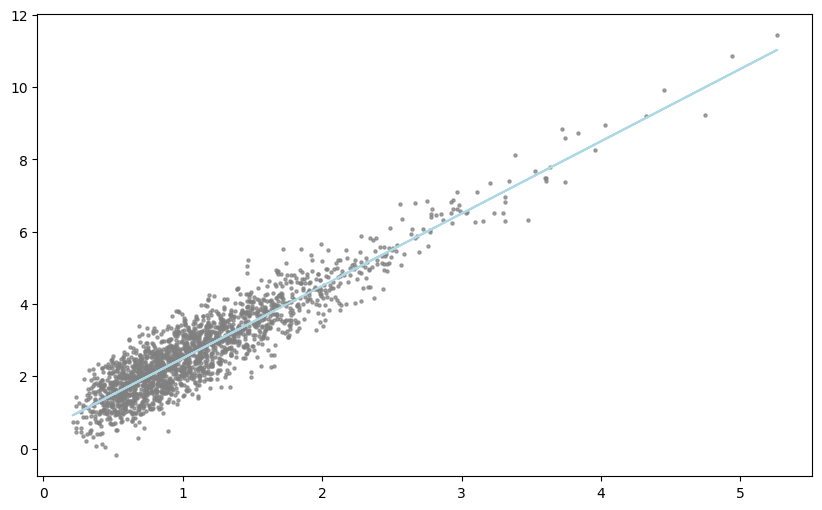

In [5]:
import matplotlib.pyplot as plt

key = random.PRNGKey(0)
x, y = data_generator(key, 2000)

y_t = 2 * x + 0.5
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='gray', s=5, alpha=0.7)
plt.plot(x, y_t, color='lightblue')


In [6]:
batch_size = 32
def create_train_loader(x, y, batch_size):
    return [(x[i : i + batch_size].reshape(-1, 1), y[i : i + batch_size].reshape(-1, 1))
            for i in range(0, len(x), batch_size)]

train_loader = create_train_loader(x, y, batch_size)

### Stochastic Gradient Descent

In [ ]:
from jax import jit, jacfwd, jacrev, vjp, jvp
import flax.linen as nn
from functools import partial

model = nn.Dense(features=1)

params = model.init(random.PRNGKey(0), jnp.ones((1, 1)))

@jit
def f(x, target, params):
    y = model.apply(params, x)
    return jnp.mean((y - target) ** 2)

lr = 1e-3

for epoch in range(1000):
    e_l = 0
    for b in train_loader:
        x_batch, target_batch = b
        fx = partial(f, x_batch, target_batch)
        loss, vjp_fn = vjp(fx, params)
        param_grad = vjp_fn(jnp.ones(()))[0]
        params = jax.tree.map(lambda p, g: p - lr * g, params, param_grad)
        e_l += loss.item()
    if epoch % 100 == 0:
        print(f"E: {epoch}, L: {e_l/len(train_loader):.4f}")

print()
print(f'{params["params"]["kernel"][0].item():.2f}x + {params["params"]["bias"][0].item():.2f}')

E: 0, L: 16.7393
E: 100, L: 0.2557
E: 200, L: 0.2454
E: 300, L: 0.2451
E: 400, L: 0.2451
E: 500, L: 0.2451
E: 600, L: 0.2451
E: 700, L: 0.2451
E: 800, L: 0.2451
E: 900, L: 0.2451

2.01x + 0.50


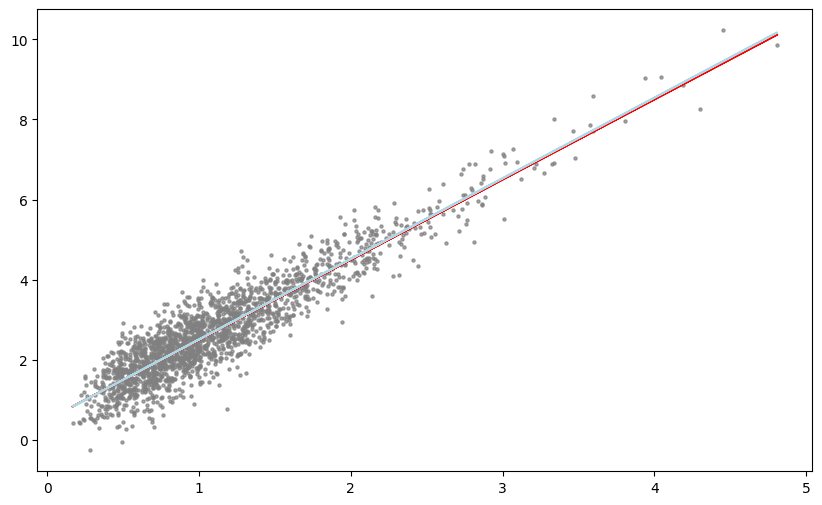

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='gray', s=5, alpha=0.7)
plt.plot(x, y_t, color='red')
plt.plot(x, model.apply(params, x.reshape(-1, 1)), color='lightblue')

In [ ]:
keys = random.split(random.PRNGKey(0), 5)
initial_params_list = [model.init(k, jnp.ones((1, 1))) for k in keys]

### Plotting Model Weight Trajectories

In [ ]:
rng = random.PRNGKey(42)
w_inits = random.uniform(rng, shape=(5,), minval=0, maxval=4)
rng, subkey = random.split(rng)
b_inits = random.uniform(subkey, shape=(5,), minval=-1.5, maxval=2.5)

initial_params_list = []
for w, b in zip(w_inits, b_inits):
    params = {"params": {"kernel": jnp.array([[w]]), "bias": jnp.array([b])}}
    initial_params_list.append(params)

@jit
def f(x, target, params):
    y = model.apply(params, x)
    return jnp.mean((y - target) ** 2)

lr = 1e-3
num_epochs = 1000

trajectories = []

for init_params in initial_params_list:
    params = init_params
    trajectory = []
    for epoch in range(num_epochs):
        e_l = 0
        for b in train_loader:
            x_batch, target_batch = b
            fx = partial(f, x_batch, target_batch)
            loss, vjp_fn = vjp(fx, params)
            param_grad = vjp_fn(jnp.ones(()))[0]
            params = jax.tree_util.tree_map(lambda p, g: p - lr * g, params, param_grad)
            e_l += loss.item()
        trajectory.append((params["params"]["kernel"][0].item(),
                           params["params"]["bias"][0].item()))
    trajectories.append(np.array(trajectory))

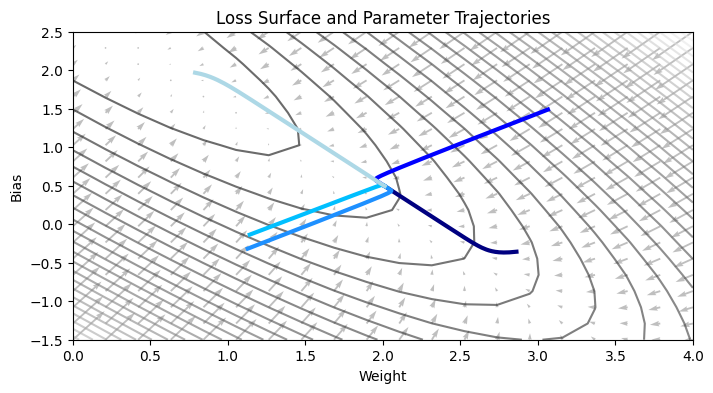

In [ ]:
w_vals = jnp.linspace(0, 4, 20)
b_vals = jnp.linspace(-1.5, 2.5, 20)
W, B = jnp.meshgrid(w_vals, b_vals)
W_flat = W.ravel()
B_flat = B.ravel()

def loss(w, b):
    params_temp = {"params": {"kernel": jnp.array([[w]]), "bias": jnp.array([b])}}
    y_pred = model.apply(params_temp, x.reshape(-1, 1))
    return jnp.mean((y_pred - y) ** 2)

def compute_risk_chunk(w_vals_chunk, b_vals_chunk):
    risks = [loss(w, b) for w, b in zip(w_vals_chunk, b_vals_chunk)]
    return jnp.array(risks)

chunk_size = 100
risk_list = []
for i in range(0, len(W_flat), chunk_size):
    w_chunk = W_flat[i:i+chunk_size]
    b_chunk = B_flat[i:i+chunk_size]
    risk_list.append(compute_risk_chunk(w_chunk, b_chunk))
Z_flat = jnp.concatenate(risk_list)
Z = Z_flat.reshape(W.shape)

grad_loss = jax.grad(loss, argnums=(0, 1))
def compute_grad_chunk(w_vals_chunk, b_vals_chunk):
    grads = [grad_loss(w, b) for w, b in zip(w_vals_chunk, b_vals_chunk)]
    grads_w = jnp.array([g[0] for g in grads])
    grads_b = jnp.array([g[1] for g in grads])
    return grads_w, grads_b

grad_w_list = []
grad_b_list = []
for i in range(0, len(W_flat), chunk_size):
    w_chunk = W_flat[i:i+chunk_size]
    b_chunk = B_flat[i:i+chunk_size]
    g_w_chunk, g_b_chunk = compute_grad_chunk(w_chunk, b_chunk)
    grad_w_list.append(g_w_chunk)
    grad_b_list.append(g_b_chunk)
grad_w_flat = jnp.concatenate(grad_w_list)
grad_b_flat = jnp.concatenate(grad_b_list)
grad_w = grad_w_flat.reshape(W.shape)
grad_b = grad_b_flat.reshape(W.shape)

plt.figure(figsize=(8, 4))
plt.contour(W, B, Z, levels=30, cmap="gray", alpha=0.6)
plt.quiver(W, B, -grad_w, -grad_b, color="gray", alpha=0.5)
colors = ["navy", "blue", "dodgerblue", "deepskyblue", "lightblue"]
for traj, color in zip(trajectories, colors):
    plt.plot(traj[:, 0], traj[:, 1], color=color, linewidth=3)
plt.xlabel("Weight")
plt.ylabel("Bias")
plt.title("Loss Surface and Parameter Trajectories")
plt.show()